In [1]:
import torch
from torch import nn
from torch.optim import *
from torchvision.datasets import *
from torchvision.transforms import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip, RandomRotation, ColorJitter, RandomGrayscale, ToTensor, Normalize
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from tqdm import tqdm
import torch.nn.utils.prune as prune
import copy
import numpy as np


In [3]:
# Define the BasicBlock class
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [4]:
# Define the ResNet class
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Function to create a ResNet18 model
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

# Create the model and move it to GPU
model = ResNet18().cuda()

In [5]:
# Define the data augmentation techniques
transforms = {
    "train": Compose([
        RandomCrop(32, padding=4),
        RandomHorizontalFlip(),
        RandomRotation(15),
        ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        RandomGrayscale(p=0.1),
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    "test": Compose([
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
}


In [6]:
# Load the CIFAR10 dataset
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )

# Create the dataloaders
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=128,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

# Split the training dataset into training and validation sets
train_dataset = dataset['train']
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create the dataloaders for the training and validation sets
batch_size = 128
dataloader = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True),
    'test': dataloader['test']
}

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Define the training function
def train(model, dataloader, criterion, optimizer):
    model.train()
    for inputs, targets in tqdm(dataloader, desc='train', leave=False):
        inputs = inputs.cuda()
        targets = targets.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

# Define the function to calculate the validation loss
def calculate_validation_loss(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    for inputs, targets in dataloader:
        inputs = inputs.cuda()
        targets = targets.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)

In [24]:
# Train the model
min_val_loss = float('inf')
patience = 20
patience_counter = 0
num_epochs = 50
for epoch in range(num_epochs):
    train(model, dataloader['train'], criterion, optimizer)
    val_loss = calculate_validation_loss(model, dataloader['val'], criterion)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss}')
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print('Early stopping')
        break
    scheduler.step()

train:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1, Validation Loss: 1.5496818489074706


Epoch 2, Validation Loss: 1.2916550008773804


Epoch 3, Validation Loss: 1.169266043663025


Epoch 4, Validation Loss: 0.9052962705612183


Epoch 5, Validation Loss: 0.9673701042175293


Epoch 6, Validation Loss: 1.0161370304107666


Epoch 7, Validation Loss: 0.8589367448806763


Epoch 8, Validation Loss: 0.7567067269325256


Epoch 9, Validation Loss: 0.769400033569336


Epoch 10, Validation Loss: 0.7611384658813477


Epoch 11, Validation Loss: 0.49359549446105955


Epoch 12, Validation Loss: 0.466042093706131


Epoch 13, Validation Loss: 0.4679991998672485


Epoch 14, Validation Loss: 0.44143570194244386


Epoch 15, Validation Loss: 0.4402107436180115


Epoch 16, Validation Loss: 0.4449911829948425


Epoch 17, Validation Loss: 0.43247821769714356


Epoch 18, Validation Loss: 0.4179987829208374


Epoch 19, Validation Loss: 0.40738549437522886


Epoch 20, Validation Loss: 0.41499297065734864


Epoch 21, Validation Loss: 0.3875271393299103


Epoch 22, Validation Loss: 0.3822109576702118


Epoch 23, Validation Loss: 0.38627809662818907


Epoch 24, Validation Loss: 0.38701479315757753


Epoch 25, Validation Loss: 0.38203621554374695


Epoch 26, Validation Loss: 0.38125322699546815


Epoch 27, Validation Loss: 0.38001804852485654


Epoch 28, Validation Loss: 0.37437315640449526


Epoch 29, Validation Loss: 0.3773530518770218


Epoch 30, Validation Loss: 0.36595945444107053


Epoch 31, Validation Loss: 0.3767201412200928


Epoch 32, Validation Loss: 0.37573688573837283


Epoch 33, Validation Loss: 0.37610849084854125


Epoch 34, Validation Loss: 0.37715803952217103


Epoch 35, Validation Loss: 0.3781751226902008


Epoch 36, Validation Loss: 0.3654918558120728


Epoch 37, Validation Loss: 0.37575388803482057


Epoch 38, Validation Loss: 0.37582590584754944


Epoch 39, Validation Loss: 0.3613237467765808


Epoch 40, Validation Loss: 0.3701188251256943


Epoch 41, Validation Loss: 0.37009437170028686


Epoch 42, Validation Loss: 0.36998495020866395


Epoch 43, Validation Loss: 0.37187491502761844


Epoch 44, Validation Loss: 0.37249222688674927


Epoch 45, Validation Loss: 0.37200254549980166


Epoch 46, Validation Loss: 0.3814457498550415


Epoch 47, Validation Loss: 0.36698203735351564


Epoch 48, Validation Loss: 0.36941740007400514


Epoch 49, Validation Loss: 0.36864945311546327


Epoch 50, Validation Loss: 0.36181534967422485


In [25]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

accuracy = evaluate(model, dataloader['test'])
print(f'Accuracy of the network on the 10000 test images: {accuracy}%')


Accuracy of the network on the 10000 test images: 90.02999877929688%


In [26]:
torch.save(model.state_dict(), 'my_resnet18_90accuracy_.pth')

In [8]:
# Initialize a new model
new_to_be_pruned_model = ResNet18().cuda()

# Load the weights from the file into the new model
new_to_be_pruned_model.load_state_dict(torch.load('my_resnet18_90accuracy_.pth'))


<All keys matched successfully>

In [9]:
def evaluate_model(model, test_loader, device, criterion = None):

    model.eval()
    model.to(device)

    running_loss = 0
    running_corrects = 0

    for inputs, labels in test_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        if criterion is not None:
            loss = criterion(outputs, labels).item()
        else:
            loss = 0

        # statistics
        running_loss += loss * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    eval_loss = running_loss / len(test_loader.dataset)
    eval_accuracy = running_corrects / len(test_loader.dataset)

    return eval_loss, eval_accuracy


In [10]:
def get_sparsity(tensor: torch.Tensor) -> float:
    
    return 1 - float(tensor.count_nonzero()) / tensor.numel()

def get_model_sparsity(model: nn.Module) -> float:
    
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements

def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    
    return get_num_parameters(model, count_nonzero_only) * data_width

class ThresholdPruning(prune.BasePruningMethod):
   
    PRUNING_TYPE = "unstructured"

    def __init__(self, threshold):
        self.threshold = threshold

    def compute_mask(self, tensor, default_mask):
        
        return torch.abs(tensor) > self.threshold

def compute_global_threshold(model, p = 15):
    
    # Python3 dict to hold weights of trained model-
    model_wts = {}
    
    for layer, params in model.named_parameters():
        model_wts[layer] = params.detach().cpu().numpy()
    
    # Python3 list to hold absolute magnitude flattened weights-
    flattened_wts = []
   
    for layer in model_wts.keys():
        flattened_wts.append(np.abs(model_wts[layer].flatten()))
    
    # Compute threshold using all weights from model-
    threshold = np.percentile(np.concatenate(flattened_wts), p)
    # print(f"threshold for {p}th percentile = {threshold:.4f}")
    
    return threshold

def compute_final_pruning_rate(pruning_rate, num_iterations):

    final_pruning_rate = 1 - (1 - pruning_rate) ** num_iterations

    return final_pruning_rate

def measure_module_sparsity(module, weight=True, bias=False, use_mask=False):

    num_zeros = 0
    num_elements = 0

    if use_mask == True:
        for buffer_name, buffer in module.named_buffers():
            if "weight_mask" in buffer_name and weight == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
            if "bias_mask" in buffer_name and bias == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
    else:
        for param_name, param in module.named_parameters():
            if "weight" in param_name and weight == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()
            if "bias" in param_name and bias == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()

    sparsity = num_zeros / num_elements

    return num_zeros, num_elements, sparsity

def measure_global_sparsity(
    model, weight = True,
    bias = False, conv2d_use_mask = False,
    linear_use_mask = False):

    num_zeros = 0
    num_elements = 0

    for module_name, module in model.named_modules():

        if isinstance(module, torch.nn.Conv2d):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=conv2d_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

        elif isinstance(module, torch.nn.Linear):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=linear_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

    sparsity = num_zeros / num_elements

    return num_zeros, num_elements, sparsity


In [2]:
num_epochs=20

In [3]:
def fine_tune_train_model(model, train_loader, test_loader, device, l1_regularization_strength = 0,
                l2_regularization_strength = 1e-4, learning_rate = 1e-1, num_epochs = num_epochs):

    # The training configurations were not carefully selected.

    criterion = nn.CrossEntropyLoss()

    model.to(device)

    # It seems that SGD optimizer is better than Adam optimizer for ResNet18 training on CIFAR10-
    optimizer = torch.optim.SGD(
        model.parameters(), lr = learning_rate,
        momentum = 0.9, weight_decay = l2_regularization_strength
    )
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    
    # Define learning rate scheduler-
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        # optimizer, milestones = [100, 150],
        optimizer, milestones = [5, 10],
        gamma = 0.1, last_epoch = -1)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500)
    

    # Evaluation-
    model.eval()
    eval_loss, eval_accuracy = evaluate_model(
        model = model, test_loader = test_loader,
        device = device, criterion = criterion)
    
    print(f"Pre fine-tuning: val_loss = {eval_loss:.3f} & val_accuracy = {eval_accuracy * 100:.3f}%")
    # print("Epoch: {:03d} Eval Loss: {:.3f} Eval Acc: {:.3f}".format(0, eval_loss, eval_accuracy))

    
    for epoch in range(num_epochs):

        # Training
        model.train()

        running_loss = 0
        running_corrects = 0

        for inputs, labels in train_loader:

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            l1_reg = torch.tensor(0.).to(device)
            for module in model.modules():
                mask = None
                weight = None
                for name, buffer in module.named_buffers():
                    if name == "weight_mask":
                        mask = buffer
                for name, param in module.named_parameters():
                    if name == "weight_orig":
                        weight = param
                # We usually only want to introduce sparsity to weights and prune weights.
                # Do the same for bias if necessary.
                if mask is not None and weight is not None:
                    l1_reg += torch.norm(mask * weight, 1)

            loss += l1_regularization_strength * l1_reg

            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = running_corrects / len(train_loader.dataset)

        # Evaluation
        model.eval()
        eval_loss, eval_accuracy = evaluate_model(
            model = model, test_loader = test_loader,
            device = device, criterion = criterion)

        # Set learning rate scheduler
        scheduler.step()
        
        print(f"epoch = {epoch + 1} loss = {train_loss:.3f}, accuracy = {train_accuracy * 100:.3f}%, val_loss = {eval_loss:.3f}, val_accuracy = {eval_accuracy * 100:.3f}% & LR: {optimizer.param_groups[0]['lr']:.4f}")

    return model


In [12]:
def iterative_pruning_finetuning(
    model, train_loader, test_loader, device,
    learning_rate, l1_regularization_strength,
    l2_regularization_strength, learning_rate_decay = 0.1,
    conv2d_prune_amount = 0.2, linear_prune_amount = 0.1,
    num_iterations = 10, num_epochs_per_iteration = 10,
    model_filename_prefix = "pruned_model", model_dir = "saved_models",
    grouped_pruning = False):
    
    best_val_acc = 0

    for i in range(1, num_iterations + 1):

        print("\nPruning and Finetuning {}/{}".format(i, num_iterations))

        print("Pruning...")


        # NOTE: For global pruning, linear/dense layer can also be pruned!
        if grouped_pruning == True:
            # grouped_pruning -> Global pruning
            parameters_to_prune = []
            for module_name, module in model.named_modules():
                if isinstance(module, torch.nn.Conv2d):
                    parameters_to_prune.append((module, "weight"))
                elif isinstance(module, torch.nn.Linear):
                    parameters_to_prune.append((module, "weight"))
            
            # Use custom absolute magnitude weight based 'global', 'unstructured' and 'iterative' pruning:
            
            # Compute threshold-
            computed_threshold = compute_global_threshold(model, p = pruning_rates[i - 1])
            # print(f"threshold for 20th percentile = {threshold}")

            prune.global_unstructured(
                parameters_to_prune,
                pruning_method = ThresholdPruning,
                threshold = computed_threshold
            )
        
        # layer-wise pruning-
        else:
            for module_name, module in model.named_modules():
                if isinstance(module, torch.nn.Conv2d):
                    prune.l1_unstructured(
                        module, name = "weight",
                        amount = conv2d_prune_amount)
                elif isinstance(module, torch.nn.Linear):
                    prune.l1_unstructured(
                        module, name = "weight",
                        amount = linear_prune_amount)

        # Compute validation accuracy just after pruning-
        _, eval_accuracy = evaluate_model(
            model = model, test_loader = test_loader,
            device = device, criterion = None)

        # Compute global sparsity-
        num_zeros, num_elements, sparsity = measure_global_sparsity(
            model, weight = True,
            bias = False, conv2d_use_mask = True,
            linear_use_mask = False)
        
        print(f"Global sparsity = {sparsity * 100:.3f}% & val_accuracy = {eval_accuracy * 100:.3f}%")
        # print(model.conv1._forward_pre_hooks)

        print("\nFine-tuning...")

        # train_model(
        fine_tuned_model = fine_tune_train_model(
            model = model, train_loader = train_loader,
            test_loader = test_loader, device = device,
            l1_regularization_strength = l1_regularization_strength,
            l2_regularization_strength = l2_regularization_strength,
            # i -> current pruning round-
            # learning_rate = learning_rate * (learning_rate_decay ** i),
            learning_rate = 1e-1,
            num_epochs = num_epochs_per_iteration)

        _, eval_accuracy = evaluate_model(
            model=model, test_loader = test_loader,
            device = device, criterion = None)

        num_zeros, num_elements, sparsity = measure_global_sparsity(
            # model,
            model, weight = True,
            bias = False, conv2d_use_mask = True,
            linear_use_mask = False)

        print(f"Post fine-tuning: Global sparsity = {sparsity * 100:.3f}% & val_accuracy = {eval_accuracy * 100:.3f}%")

    return model


In [13]:
def remove_parameters(model):

    for module_name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            try:
                prune.remove(module, "weight")
            except:
                pass
            try:
                prune.remove(module, "bias")
            except:
                pass
        elif isinstance(module, torch.nn.Linear):
            try:
                prune.remove(module, "weight")
            except:
                pass
            try:
                prune.remove(module, "bias")
            except:
                pass

    return model


In [14]:
def create_classification_report(model, device, test_loader):

    model.eval()
    model.to(device)

    y_pred = []
    y_true = []

    with torch.no_grad():
        for data in test_loader:
            y_true += data[1].numpy().tolist()
            images, _ = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred += predicted.cpu().numpy().tolist()

    classification_report = sklearn.metrics.classification_report(
        y_true = y_true, y_pred = y_pred)

    return classification_report


In [15]:
from tqdm.notebook import tqdm

def sensitivity_analysis(model, train_loader, test_loader, device, num_epochs):
    # Store the original state of the model
    original_state_dict = copy.deepcopy(model.state_dict())

    # Define the sparsity levels you want to test
    sparsity_levels = [0.1, 0.5, 0.9]  # fewer sparsity levels

    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):  # only Conv2d layers
            # Store the original state of the layer
            original_weights = copy.deepcopy(module.weight.data)

            for sparsity in sparsity_levels:
                # Prune the layer
                threshold = np.percentile(torch.abs(original_weights).cpu().numpy(), sparsity * 100)
                pruning_method = ThresholdPruning(threshold)
                prune.custom_from_mask(module, name='weight', mask=pruning_method.compute_mask(module.weight, default_mask=None))

                # Fine-tune the model
                fine_tune_train_model(model, train_loader, test_loader, device, num_epochs=num_epochs)  # fewer epochs

                # Evaluate the model
                _, accuracy = evaluate_model(model, test_loader, device, criterion=None)

                print(f"Layer: {name}, Sparsity: {sparsity * 100}%, Accuracy: {accuracy}%")

                # Reset the weights of the layer to their original state
                module.weight.data = original_weights

    # Reset the weights of the model to their original state
    model.load_state_dict(original_state_dict)


In [16]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def prepare_data_loaders(batch_size=64):
    # Define the data transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load the CIFAR-10 datasets
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Create the data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


In [17]:
# Load the model
model = new_to_be_pruned_model

# Prepare your data loaders
train_loader, test_loader = prepare_data_loaders()

# Specify the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


Sensitivity Scan

In [19]:
# Load the model
model = new_to_be_pruned_model

# Prepare your data loaders
train_loader, test_loader = prepare_data_loaders()

# Specify the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Run the sensitivity analysis with 5 epochs for fine-tuning
sensitivity_analysis(model, train_loader, test_loader, device, num_epochs=5)



Files already downloaded and verified
Files already downloaded and verified
Pre fine-tuning: val_loss = 0.312 & val_accuracy = 90.030%
epoch = 1 loss = 0.782, accuracy = 73.160%, val_loss = 0.593, val_accuracy = 79.990% & LR: 0.1000
epoch = 2 loss = 0.489, accuracy = 83.152%, val_loss = 0.613, val_accuracy = 78.940% & LR: 0.1000
epoch = 3 loss = 0.391, accuracy = 86.404%, val_loss = 0.578, val_accuracy = 80.740% & LR: 0.1000
epoch = 4 loss = 0.321, accuracy = 88.872%, val_loss = 0.522, val_accuracy = 83.080% & LR: 0.1000
epoch = 5 loss = 0.273, accuracy = 90.482%, val_loss = 0.523, val_accuracy = 83.000% & LR: 0.0100
Layer: conv1, Sparsity: 10.0%, Accuracy: 0.8299999833106995%
Pre fine-tuning: val_loss = 0.630 & val_accuracy = 79.490%
epoch = 1 loss = 0.238, accuracy = 91.604%, val_loss = 0.828, val_accuracy = 77.270% & LR: 0.1000
epoch = 2 loss = 0.209, accuracy = 92.658%, val_loss = 0.483, val_accuracy = 84.480% & LR: 0.1000
epoch = 3 loss = 0.174, accuracy = 93.848%, val_loss = 0.54

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "layer1.0.conv1.weight_orig", "layer1.0.conv1.weight_mask", "layer1.0.conv2.weight_orig", "layer1.0.conv2.weight_mask", "layer1.1.conv1.weight_orig", "layer1.1.conv1.weight_mask", "layer1.1.conv2.weight_orig", "layer1.1.conv2.weight_mask", "layer2.0.conv1.weight_orig", "layer2.0.conv1.weight_mask", "layer2.0.conv2.weight_orig", "layer2.0.conv2.weight_mask", "layer2.0.shortcut.0.weight_orig", "layer2.0.shortcut.0.weight_mask", "layer2.1.conv1.weight_orig", "layer2.1.conv1.weight_mask", "layer2.1.conv2.weight_orig", "layer2.1.conv2.weight_mask", "layer3.0.conv1.weight_orig", "layer3.0.conv1.weight_mask", "layer3.0.conv2.weight_orig", "layer3.0.conv2.weight_mask", "layer3.0.shortcut.0.weight_orig", "layer3.0.shortcut.0.weight_mask", "layer3.1.conv1.weight_orig", "layer3.1.conv1.weight_mask", "layer3.1.conv2.weight_orig", "layer3.1.conv2.weight_mask", "layer4.0.conv1.weight_orig", "layer4.0.conv1.weight_mask", "layer4.0.conv2.weight_orig", "layer4.0.conv2.weight_mask", "layer4.0.shortcut.0.weight_orig", "layer4.0.shortcut.0.weight_mask", "layer4.1.conv1.weight_orig", "layer4.1.conv1.weight_mask", "layer4.1.conv2.weight_orig", "layer4.1.conv2.weight_mask". 
	Unexpected key(s) in state_dict: "layer1.0.conv1.weight", "layer1.0.conv2.weight", "layer1.1.conv1.weight", "layer1.1.conv2.weight", "layer2.0.conv1.weight", "layer2.0.conv2.weight", "layer2.0.shortcut.0.weight", "layer2.1.conv1.weight", "layer2.1.conv2.weight", "layer3.0.conv1.weight", "layer3.0.conv2.weight", "layer3.0.shortcut.0.weight", "layer3.1.conv1.weight", "layer3.1.conv2.weight", "layer4.0.conv1.weight", "layer4.0.conv2.weight", "layer4.0.shortcut.0.weight", "layer4.1.conv1.weight", "layer4.1.conv2.weight". 

Ignore the error, very minor mistake in the end, didn't realise before running ;(
    
The sensitivity analysis is done, it took approx 6hours+ for this to run even on dedicated rtx gpu

In [18]:
# Load the model
model = new_to_be_pruned_model

In [19]:
# Compute final pruning rate using 20% global unstructured pruning with 21 such pruning rounds
pruning_rates = []
for i in range(1, 22):
    final_pruning_rate = compute_final_pruning_rate(pruning_rate = 0.2, num_iterations = i)
    pruning_rates.append(final_pruning_rate * 100)

In [20]:
# Set regularization strengths and learning rate
l1_regularization_strength = 0
l2_regularization_strength = 1e-4
learning_rate = 1e-3

In [21]:
# Evaluate the pre-trained model
_, eval_accuracy = evaluate_model(
    model = model, test_loader=test_loader,
    device = device, criterion = None)

In [26]:
# Measure the sparsity of the pre-trained model
num_zeros, num_elements, sparsity = measure_global_sparsity(model)
print(f"Global sparsity = {sparsity:.3f}% & val_accuracy = {eval_accuracy * 100:.3f}%")

Global sparsity = 0.000% & val_accuracy = 90.030%


In [26]:
# Create a deep copy of the pre-trained model
pruned_model = copy.deepcopy(model)

In [27]:
learning_rate_decay = 0.1
model_filename_prefix = "pruned_model"
model_dir = "/home/akshat_gosain/SAiDL/"

In [28]:
# Perform iterative pruning and fine-tuning
pruned_model = iterative_pruning_finetuning(
        model = pruned_model, train_loader = train_loader,
        test_loader = test_loader, device = device,
        learning_rate = learning_rate, learning_rate_decay = learning_rate_decay,
        l1_regularization_strength = l1_regularization_strength, l2_regularization_strength = l2_regularization_strength,
        conv2d_prune_amount = 0.2, linear_prune_amount = 0.1,
        num_iterations = 21, num_epochs_per_iteration = 12,
        model_filename_prefix = model_filename_prefix, model_dir = model_dir,
        grouped_pruning = True)



Pruning and Finetuning 1/21
Pruning...
Global sparsity = 20.017% & val_accuracy = 90.030%

Fine-tuning...
Pre fine-tuning: val_loss = 0.311 & val_accuracy = 90.030%
epoch = 1 loss = 0.780, accuracy = 73.136%, val_loss = 0.711, val_accuracy = 75.750% & LR: 0.1000
epoch = 2 loss = 0.490, accuracy = 83.272%, val_loss = 0.556, val_accuracy = 81.100% & LR: 0.1000
epoch = 3 loss = 0.390, accuracy = 86.496%, val_loss = 0.569, val_accuracy = 81.250% & LR: 0.1000
epoch = 4 loss = 0.319, accuracy = 88.874%, val_loss = 0.506, val_accuracy = 83.180% & LR: 0.1000
epoch = 5 loss = 0.271, accuracy = 90.596%, val_loss = 0.521, val_accuracy = 83.170% & LR: 0.0100
epoch = 6 loss = 0.104, accuracy = 96.582%, val_loss = 0.330, val_accuracy = 89.430% & LR: 0.0100
epoch = 7 loss = 0.053, accuracy = 98.438%, val_loss = 0.351, val_accuracy = 89.390% & LR: 0.0100
epoch = 8 loss = 0.034, accuracy = 99.044%, val_loss = 0.375, val_accuracy = 89.220% & LR: 0.0100
epoch = 9 loss = 0.021, accuracy = 99.530%, val_lo

In [29]:
# Apply pruned mask to the parameters/weights and remove the masks
remove_parameters(model = pruned_model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [30]:
# Evaluate the pruned model
_, eval_accuracy = evaluate_model(
    model = pruned_model, test_loader = test_loader,
    device = device, criterion = None)


In [31]:
# Measure the sparsity of the pruned model
num_zeros, num_elements, sparsity = measure_global_sparsity(pruned_model)
print(f"Global sparsity = {sparsity:.3f} & val_accuracy = {eval_accuracy:.3f}")

Global sparsity = 0.991 & val_accuracy = 0.886


In [ ]:
# Remove pruning parameters
final_model = remove_parameters(pruned_model)

In [33]:
# Evaluate the final model
_, eval_accuracy = evaluate_model(
    model = final_model, test_loader = test_loader,
    device = device, criterion = None)

In [34]:
# Measure the sparsity of the final model
num_zeros, num_elements, sparsity = measure_global_sparsity(pruned_model)
print(f"Global sparsity = {sparsity * 100:.3f}% & val_accuracy = {eval_accuracy * 100:.3f}%")

Global sparsity = 99.122% & val_accuracy = 88.590%


In [35]:
# Save the final model
torch.save(final_model.state_dict(), f"ResNet18_trained_sparsity-{sparsity * 100:.3f}.pth")

In [22]:
# Load the final model for a sanity check
trained_pruned_model = ResNet18()
trained_pruned_model.load_state_dict(torch.load('ResNet18_trained_sparsity-99.122.pth'))

# Move model to GPU (if available)
trained_pruned_model.to(device)

# Define cost function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
        trained_pruned_model.parameters(), lr = learning_rate,
        momentum = 0.9, weight_decay = l2_regularization_strength
)

In [23]:
# Evaluate the final model
eval_loss, eval_accuracy = evaluate_model(
    model = trained_pruned_model, test_loader=test_loader,
    device = device, criterion = None)


In [29]:
# Measure the sparsity of the final model
num_zeros, num_elements, sparsity = measure_global_sparsity(trained_pruned_model)
print(f"Global sparsity = {sparsity * 100:.3f}%, val_loss = {eval_loss:.3f} & val_accuracy = {eval_accuracy * 100:.3f}%")

Global sparsity = 99.122%, val_loss = 0.000 & val_accuracy = 88.590%


This is the final accuracy above

Bonus task below

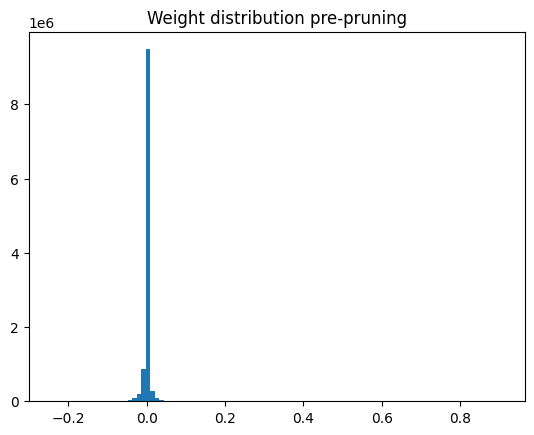

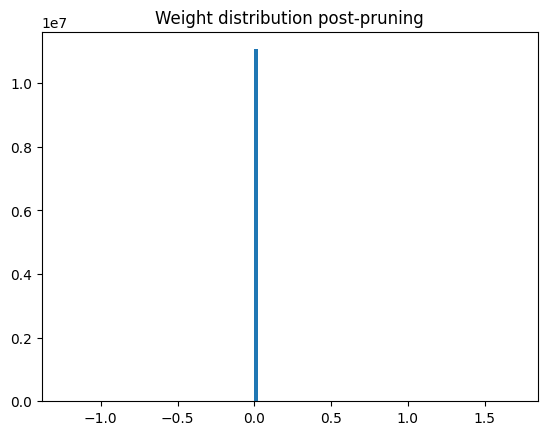

Mean activation: 0.244963139295578


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_weight_distribution(model, title):
    weights = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights += list(param.cpu().detach().numpy().flatten())
    plt.hist(weights, bins=100)
    plt.title(title)
    plt.show()
    plt.close()  # Close the plot to free up memory

# Move the model to CPU to free up GPU memory
trained_pruned_model.to('cpu')

# Plot the weight distribution for layers pre-pruning
plot_weight_distribution(new_to_be_pruned_model, "Weight distribution pre-pruning")

# Plot the weight distribution for layers post-pruning
plot_weight_distribution(trained_pruned_model, "Weight distribution post-pruning")

def check_activation_balance(model, dataloader):
    model.eval()
    activations = []
    for inputs, _ in dataloader:
        inputs = inputs.to('cpu')  # Move inputs to CPU to free up GPU memory
        outputs = model(inputs)
        activations.append(outputs.detach().numpy())
    activations = np.concatenate(activations)
    mean_activation = np.mean(activations)
    print(f"Mean activation: {mean_activation}")

# Check the balance of the activations when input is passed
check_activation_balance(trained_pruned_model, test_loader)